In [1]:
from utils import CNNBackbone, LSTMBackbone, get_device, SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, Classifier, train, set_seed, plot_train_val_losses, test_model, get_regression_report, create_folder
import torch.optim as optim
import numpy as np
import torch

DATA_PATH = "/home/alex/Downloads/archive(1)/data/"
EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 32
RANDOM_SEED = 42
RNN_HIDDEN_SIZE = 64
NUM_CATEGORIES = 1
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 256
DEVICE = get_device()


create_folder("model_weights"), create_folder("assets")

(None, None)

### Prepare Data

Regression = 1 for Valence Labels

Regression = 2 for Valence Energy

Regression = 3 for Valence Dancability

In [2]:
valence_data = SpectrogramDataset(DATA_PATH + "multitask_dataset/", class_mapping=CLASS_MAPPING, train=True, regression=1)
energy_data = SpectrogramDataset(DATA_PATH + "multitask_dataset/", class_mapping=CLASS_MAPPING, train=True, regression=2)
dancability_data = SpectrogramDataset(DATA_PATH + "multitask_dataset/", class_mapping=CLASS_MAPPING, train=True, regression=3)

valence_train_dl, valence_val_dl = torch_train_val_split(dataset=valence_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
energy_train_dl, energy_val_dl = torch_train_val_split(dataset=energy_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
dancability_train_dl, dancability_val_dl = torch_train_val_split(dataset=dancability_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)

### Overfit LSTM model on one batch to make sure everything works

In [6]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(dancability_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=False)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train(model, dancability_train_dl, dancability_val_dl, optimizer, EPOCHS, device=DEVICE, overfit_batch=True, regression_flag=True)

Training in overfitting mode...
Epoch 1, Loss at training set: 0.3127734065055847
Epoch 20, Loss at training set: 0.0855160504579544
Epoch 40, Loss at training set: 0.03436131775379181
Epoch 60, Loss at training set: 0.03602365776896477
Epoch 80, Loss at training set: 0.034296032041311264
Epoch 100, Loss at training set: 0.034681133925914764
Epoch 120, Loss at training set: 0.034483205527067184
Epoch 140, Loss at training set: 0.034552719444036484
Epoch 160, Loss at training set: 0.03444863483309746
Epoch 180, Loss at training set: 0.033841148018836975
Epoch 200, Loss at training set: 0.034361690282821655
Epoch 220, Loss at training set: 0.03413303196430206
Epoch 240, Loss at training set: 0.03377964347600937
Epoch 260, Loss at training set: 0.03408164530992508
Epoch 280, Loss at training set: 0.03394085168838501
Epoch 300, Loss at training set: 0.03466195613145828
Epoch 320, Loss at training set: 0.03442860394716263
Epoch 340, Loss at training set: 0.03386349976062775
Epoch 360, Loss 

### Overfit CNN model on one batch to make sure everything works

In [5]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(dancability_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train(model, dancability_train_dl, dancability_val_dl, optimizer, EPOCHS, device=DEVICE, overfit_batch=True, regression_flag=True)

Training in overfitting mode...


/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss at training set: 0.07149834930896759
Epoch 20, Loss at training set: 217.63427734375
Epoch 40, Loss at training set: 36.52733612060547
Epoch 60, Loss at training set: 3.4134106636047363
Epoch 80, Loss at training set: 0.1795535534620285
Epoch 100, Loss at training set: 0.03738268092274666
Epoch 120, Loss at training set: 0.028610192239284515
Epoch 140, Loss at training set: 0.02894960157573223
Epoch 160, Loss at training set: 0.02835691161453724
Epoch 180, Loss at training set: 0.028295882046222687
Epoch 200, Loss at training set: 0.028276540338993073
Epoch 220, Loss at training set: 0.02827426604926586
Epoch 240, Loss at training set: 0.028273914009332657
Epoch 260, Loss at training set: 0.02827388048171997
Epoch 280, Loss at training set: 0.028273876756429672
Epoch 300, Loss at training set: 0.028273876756429672
Epoch 320, Loss at training set: 0.028273876756429672
Epoch 340, Loss at training set: 0.028273876756429672
Epoch 360, Loss at training set: 0.02827387675642967

### Train LSTM Regressor on Valence Dataset

Training started for model model_weights/lstm_valence_best...


/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100
	Average Training Loss: 0.09474808876884394 (3.34s)
	Average Validation Loss: 0.03836754869137492(0.42s)
Epoch 2/100
	Average Training Loss: 0.03458370412860451 (3.25s)
	Average Validation Loss: 0.03111516684293747(0.41s)
Epoch 3/100
	Average Training Loss: 0.034074139235348536 (3.24s)
	Average Validation Loss: 0.03081208573920386(0.42s)
Epoch 4/100
	Average Training Loss: 0.03338966242455203 (3.24s)
	Average Validation Loss: 0.030761390126177242(0.44s)
Epoch 5/100
	Average Training Loss: 0.03263809718191624 (3.24s)
	Average Validation Loss: 0.03067545938704695(0.45s)
Epoch 6/100
	Average Training Loss: 0.033369517082284236 (3.23s)
	Average Validation Loss: 0.030674106308392117(0.45s)
Epoch 7/100
	Average Training Loss: 0.033884406667845 (3.24s)
	Average Validation Loss: 0.03048249227660043(0.41s)
Epoch 8/100
	Average Training Loss: 0.03432910658162216 (3.20s)
	Average Validation Loss: 0.030443027349455015(0.43s)
Epoch 9/100
	Average Training Loss: 0.03291883377422546 (3.22

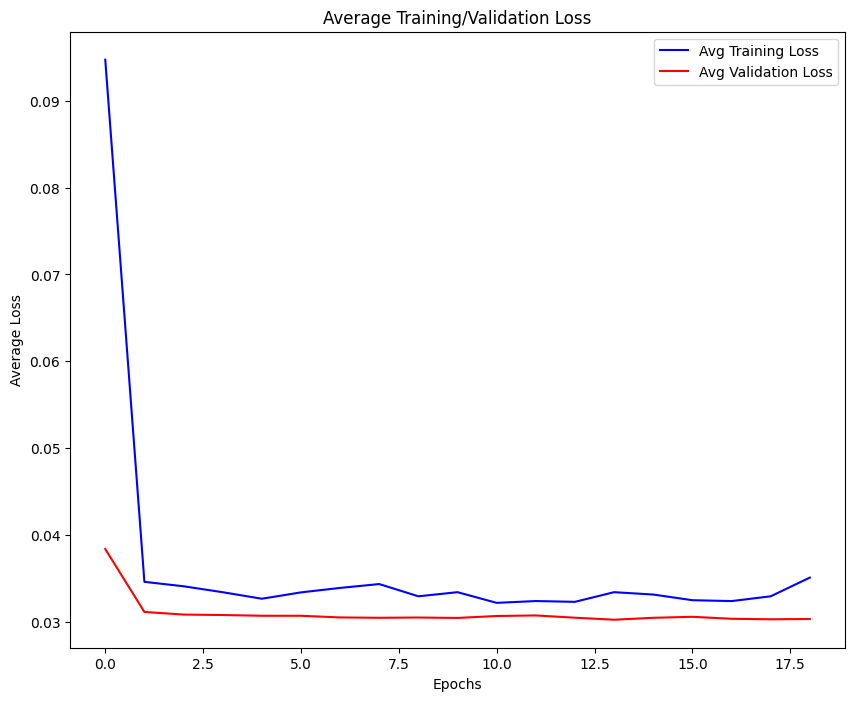

In [6]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(valence_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = train(model, dancability_train_dl, dancability_val_dl, optimizer, EPOCHS, 
      device=DEVICE, overfit_batch=False, regression_flag=True, save_path="model_weights/lstm_valence_best.pth")

plot_train_val_losses(train_losses, val_losses, save_title="assets/lstm_valence_train_val_losses.png")


### Eval LSTM Regressor on Valence Dataset

In [3]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(valence_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
model.load_state_dict(torch.load("model_weights/lstm_valence_best.pth", weights_only=True, map_location=DEVICE))
y_true, y_pred, spear_corrs = test_model(model, valence_val_dl, DEVICE, regression_flag=True)
print("LSTM Regressor on Valence Dataset")
get_regression_report(y_pred, y_true, spear_corrs)

LSTM Regressor on Valence Dataset
	Spearman Correlation: 0.0254
	MSE: 0.0689
	MAE: 0.2246
	RMSE: 0.2624


### Train CNN Regressor on Valence Dataset

Training started for model model_weights/cnn_valence_best...


/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100
	Average Training Loss: 799.1036223250217 (8.62s)
	Average Validation Loss: 162.3022918701172(0.75s)
Epoch 2/100
	Average Training Loss: 26.066753814960347 (8.16s)
	Average Validation Loss: 2.349960310118539(0.75s)
Epoch 3/100
	Average Training Loss: 3.3916168952810355 (8.14s)
	Average Validation Loss: 0.9215590953826904(0.73s)
Epoch 4/100
	Average Training Loss: 1.1694966410768444 (8.17s)
	Average Validation Loss: 0.5650197906153542(0.74s)
Epoch 5/100
	Average Training Loss: 0.4975299123546173 (8.23s)
	Average Validation Loss: 0.3203367867640087(0.76s)
Epoch 6/100
	Average Training Loss: 0.39397929172063695 (8.19s)
	Average Validation Loss: 0.3611771421773093(0.75s)
Epoch 7/100
	Average Training Loss: 0.3472845682810093 (8.14s)
	Average Validation Loss: 0.2637642579419272(0.74s)
Epoch 8/100
	Average Training Loss: 0.32906512890396444 (8.15s)
	Average Validation Loss: 0.18054139401231492(0.73s)
Epoch 9/100
	Average Training Loss: 0.2431426063693803 (8.18s)
	Average Validati

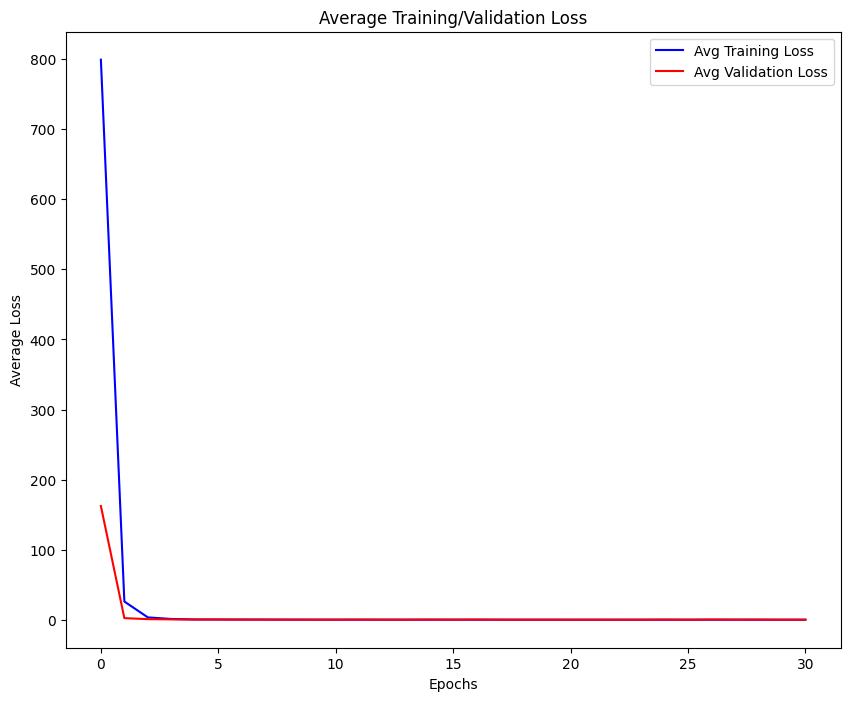

In [4]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(valence_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)


train_losses, val_losses = train(model, valence_train_dl, valence_val_dl, optimizer, EPOCHS, 
      device=DEVICE, overfit_batch=False, regression_flag=True, save_path="model_weights/cnn_valence_best.pth")

plot_train_val_losses(train_losses, val_losses, save_title="assets/cnn_valence_train_val_losses.png")


### Eval CNN Regressor on Valence Dataset

In [5]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(valence_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
model.load_state_dict(torch.load("model_weights/cnn_valence_best.pth", weights_only=True, map_location=DEVICE))
y_true, y_pred, spear_corrs = test_model(model, valence_val_dl, DEVICE, regression_flag=True)
print("CNN Regressor on Valence Dataset")
get_regression_report(y_pred, y_true, spear_corrs)

CNN Regressor on Valence Dataset
	Spearman Correlation: -0.0183
	MSE: 0.0896
	MAE: 0.2459
	RMSE: 0.2993


### Train AST Regressor on Valence Dataset

### Eval AST Regressor on Valence Dataset

### Train LSTM Regressor on Energy Dataset

Training started for model model_weights/lstm_energy_best...


/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100
	Average Training Loss: 0.09643534423205359 (3.37s)
	Average Validation Loss: 0.039543156645127704(0.44s)
Epoch 2/100
	Average Training Loss: 0.03874141478846813 (3.25s)
	Average Validation Loss: 0.03137263496007238(0.41s)
Epoch 3/100
	Average Training Loss: 0.03642023984214355 (3.34s)
	Average Validation Loss: 0.03124008434159415(0.42s)
Epoch 4/100
	Average Training Loss: 0.032546267812622 (3.21s)
	Average Validation Loss: 0.030952603157077516(0.42s)
Epoch 5/100
	Average Training Loss: 0.03390899930020858 (3.31s)
	Average Validation Loss: 0.03093232453933784(0.41s)
Epoch 6/100
	Average Training Loss: 0.03448147121174582 (3.25s)
	Average Validation Loss: 0.03065000953418868(0.42s)
Epoch 7/100
	Average Training Loss: 0.03289352813414458 (3.26s)
	Average Validation Loss: 0.030616473140461103(0.42s)
Epoch 8/100
	Average Training Loss: 0.035480949513871096 (3.18s)
	Average Validation Loss: 0.030574808695486615(0.42s)
Epoch 9/100
	Average Training Loss: 0.034030523151159286 (3.2

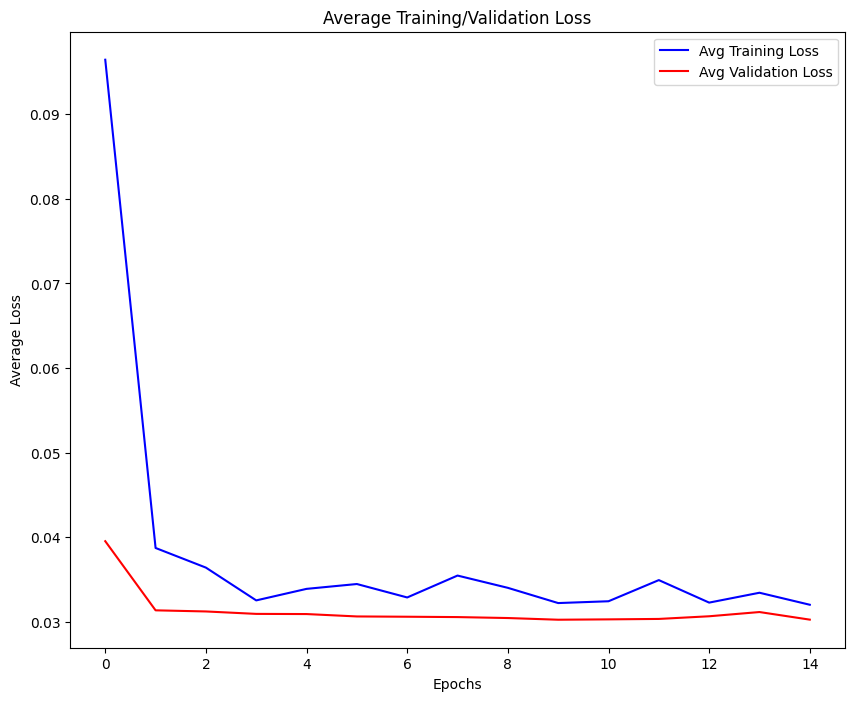

In [6]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(energy_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = train(model, dancability_train_dl, dancability_val_dl, optimizer, EPOCHS, 
      device=DEVICE, overfit_batch=False, regression_flag=True, save_path="model_weights/lstm_energy_best.pth")

plot_train_val_losses(train_losses, val_losses, save_title="assets/lstm_energy_train_val_losses.png")


### Eval LSTM Regressor on Energy Dataset

In [6]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(energy_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
model.load_state_dict(torch.load("model_weights/lstm_energy_best.pth", weights_only=True, map_location=DEVICE))
y_true, y_pred, spear_corrs = test_model(model, energy_val_dl, DEVICE, regression_flag=True)
print("LSTM Regressor on Energy Dataset")
get_regression_report(y_pred, y_true, spear_corrs)

LSTM Regressor on Energy Dataset
	Spearman Correlation: 0.0944
	MSE: 0.0659
	MAE: 0.2228
	RMSE: 0.2567


### Train CNN Regressor on Energy Dataset

Training started for model model_weights/cnn_energy_best...


/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100
	Average Training Loss: 993.0638104890442 (8.45s)
	Average Validation Loss: 83.22134835379464(0.72s)
Epoch 2/100
	Average Training Loss: 39.379732140179335 (8.54s)
	Average Validation Loss: 9.875640732901436(0.75s)
Epoch 3/100
	Average Training Loss: 4.051294319588562 (8.44s)
	Average Validation Loss: 0.7209457244191851(0.72s)
Epoch 4/100
	Average Training Loss: 0.7106701813895127 (8.45s)
	Average Validation Loss: 0.4677219774041857(0.74s)
Epoch 5/100
	Average Training Loss: 0.46872437205807915 (8.47s)
	Average Validation Loss: 0.39756143944604055(0.75s)
Epoch 6/100
	Average Training Loss: 0.4917442130631414 (8.70s)
	Average Validation Loss: 0.3482494481972286(0.74s)
Epoch 7/100
	Average Training Loss: 0.33684635522036716 (8.54s)
	Average Validation Loss: 0.19332646684987204(0.74s)
Epoch 8/100
	Average Training Loss: 0.211946665726859 (8.72s)
	Average Validation Loss: 0.15634702465363912(0.76s)
Epoch 9/100
	Average Training Loss: 0.17773375454647788 (8.49s)
	Average Validat

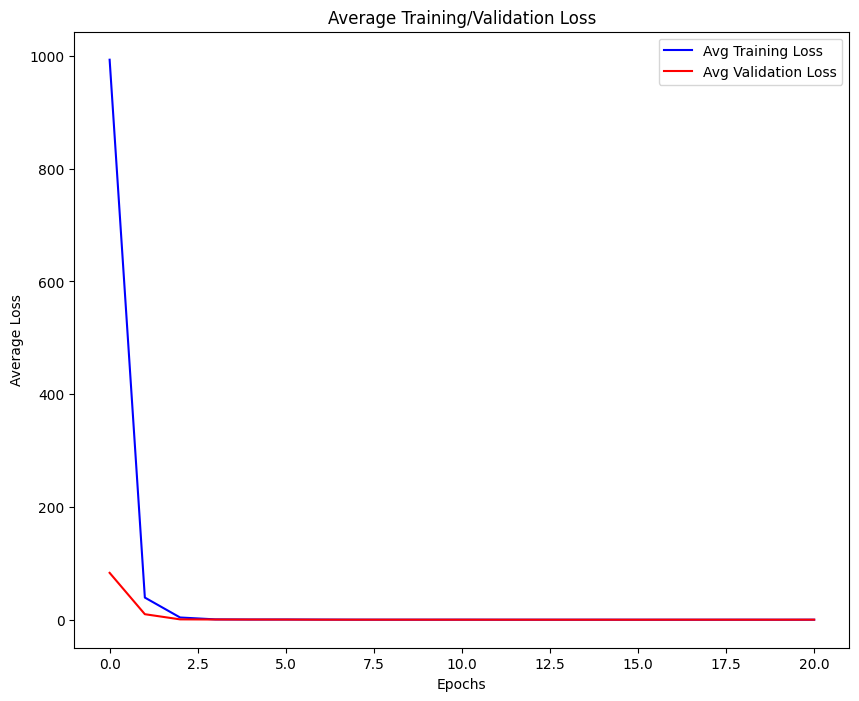

In [5]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(energy_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)


train_losses, val_losses = train(model, energy_train_dl, energy_val_dl, optimizer, EPOCHS, 
      device=DEVICE, overfit_batch=False, regression_flag=True, save_path="model_weights/cnn_energy_best.pth")

plot_train_val_losses(train_losses, val_losses, save_title="assets/cnn_energy_train_val_losses.png")


### Eval CNN Regressor on Energy Dataset

In [7]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(energy_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
model.load_state_dict(torch.load("model_weights/cnn_energy_best.pth", weights_only=True, map_location=DEVICE))
y_true, y_pred, spear_corrs = test_model(model, energy_val_dl, DEVICE, regression_flag=True)
print("CNN Regressor on Energy Dataset")
get_regression_report(y_pred, y_true, spear_corrs)

CNN Regressor on Energy Dataset
	Spearman Correlation: 0.0824
	MSE: 0.0864
	MAE: 0.2341
	RMSE: 0.2939


### Train AST Regressor on Valance Dataset

### Train LSTM Regressor on Dancability Dataset

Training started for model model_weights/lstm_dancability_best...


/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100
	Average Training Loss: 0.09643534423205359 (3.16s)
	Average Validation Loss: 0.039543156645127704(0.41s)
Epoch 2/100
	Average Training Loss: 0.03874141478846813 (3.10s)
	Average Validation Loss: 0.03137263496007238(0.41s)
Epoch 3/100
	Average Training Loss: 0.03642023984214355 (3.15s)
	Average Validation Loss: 0.03124008434159415(0.42s)
Epoch 4/100
	Average Training Loss: 0.032546267812622 (3.18s)
	Average Validation Loss: 0.030952603157077516(0.42s)
Epoch 5/100
	Average Training Loss: 0.03390899930020858 (3.18s)
	Average Validation Loss: 0.03093232453933784(0.42s)
Epoch 6/100
	Average Training Loss: 0.03448147121174582 (3.20s)
	Average Validation Loss: 0.03065000953418868(0.43s)
Epoch 7/100
	Average Training Loss: 0.03289352813414458 (3.30s)
	Average Validation Loss: 0.030616473140461103(0.45s)
Epoch 8/100
	Average Training Loss: 0.035480949513871096 (3.34s)
	Average Validation Loss: 0.030574808695486615(0.44s)
Epoch 9/100
	Average Training Loss: 0.034030523151159286 (3.3

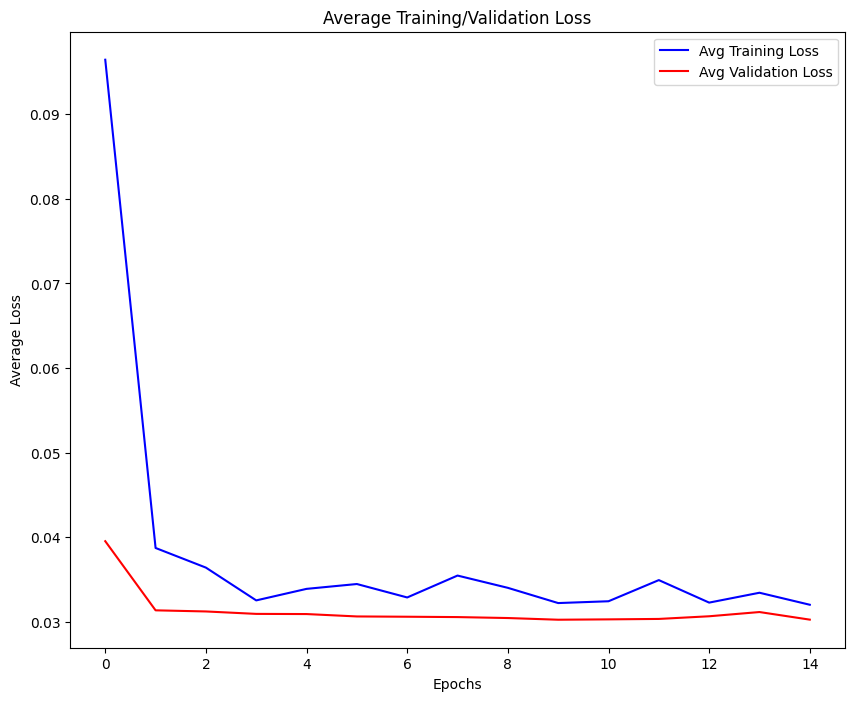

In [7]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(dancability_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = train(model, dancability_train_dl, dancability_val_dl, optimizer, EPOCHS, 
      device=DEVICE, overfit_batch=False, regression_flag=True, save_path="model_weights/lstm_dancability_best.pth")

plot_train_val_losses(train_losses, val_losses, save_title="assets/lstm_dancability_train_val_losses.png")


### Eval LSTM Regressor on Dancability Dataset

In [8]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(dancability_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
model.load_state_dict(torch.load("model_weights/lstm_dancability_best.pth", weights_only=True, map_location=DEVICE))
y_true, y_pred, spear_corrs = test_model(model, dancability_val_dl, DEVICE, regression_flag=True)
print("LSTM Regressor on Dancability Dataset")
get_regression_report(y_pred, y_true, spear_corrs)

LSTM Regressor on Dancability Dataset
	Spearman Correlation: -0.0172
	MSE: 0.0304
	MAE: 0.1396
	RMSE: 0.1745


### Train CNN Regressor on Dancability Dataset

Training started for model model_weights/cnn_dancability_best...
Epoch 1/100
	Average Training Loss: 437.09670911832103 (8.44s)
	Average Validation Loss: 74.01073673793248(0.75s)
Epoch 2/100
	Average Training Loss: 18.387383078706677 (8.44s)
	Average Validation Loss: 7.963089397975376(0.73s)
Epoch 3/100
	Average Training Loss: 2.321392756083916 (8.43s)
	Average Validation Loss: 1.1007489987782069(0.75s)
Epoch 4/100
	Average Training Loss: 1.2662798371808281 (8.43s)
	Average Validation Loss: 2.8389996119907925(0.75s)
Epoch 5/100
	Average Training Loss: 1.2002785061967784 (8.46s)
	Average Validation Loss: 0.18555907053606852(0.74s)
Epoch 6/100
	Average Training Loss: 0.4648689802350669 (8.44s)
	Average Validation Loss: 0.14135643733399256(0.73s)
Epoch 7/100
	Average Training Loss: 0.38565036448939094 (8.41s)
	Average Validation Loss: 0.36290060196604046(0.74s)
Epoch 8/100
	Average Training Loss: 0.2861617993691872 (8.39s)
	Average Validation Loss: 0.3786408943789346(0.73s)
Epoch 9/100
	A

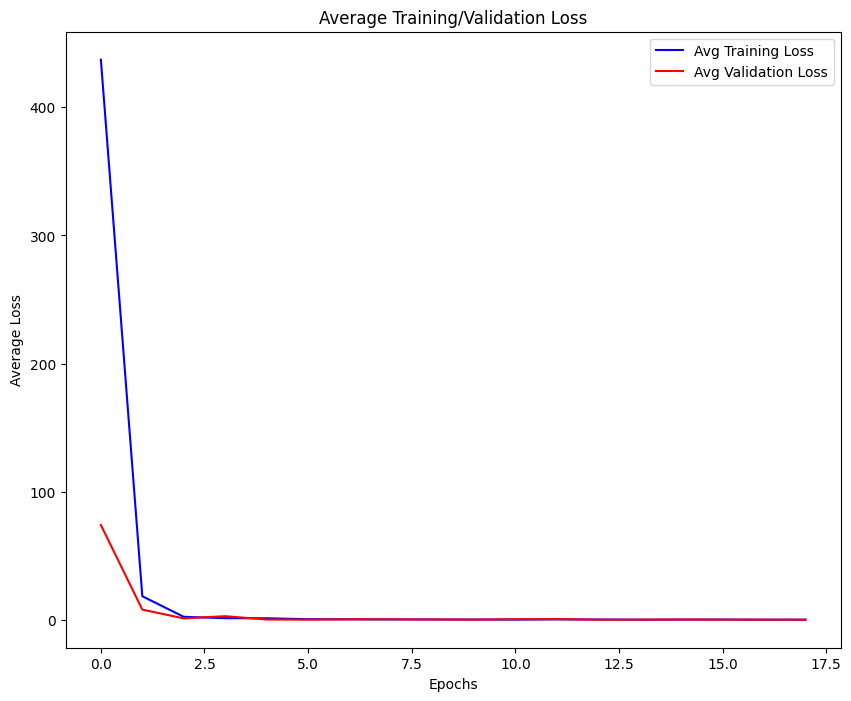

In [6]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(dancability_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)


train_losses, val_losses = train(model, dancability_train_dl, dancability_val_dl, optimizer, EPOCHS, 
      device=DEVICE, overfit_batch=False, regression_flag=True, save_path="model_weights/cnn_dancability_best.pth")

plot_train_val_losses(train_losses, val_losses, save_title="assets/cnn_dancability_train_val_losses.png")


### Eval CNN Regressor on Dancability Dataset

In [9]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(dancability_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
model.load_state_dict(torch.load("model_weights/cnn_dancability_best.pth", weights_only=True, map_location=DEVICE))
y_true, y_pred, spear_corrs = test_model(model, dancability_val_dl, DEVICE, regression_flag=True)
print("CNN Regressor on Dancability Dataset")
get_regression_report(y_pred, y_true, spear_corrs)

CNN Regressor on Dancability Dataset
	Spearman Correlation: 0.0630
	MSE: 0.0608
	MAE: 0.1992
	RMSE: 0.2465


### Train AST Regressor on Dancability Dataset